In [148]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import math
import random

from torch.autograd import Variable

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [149]:
in_dim, hid1_dim, hid2_dim, out_dim = 4, 8, 9, 3

In [150]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [151]:
# 가중치를 저장하기 위한 무작위 값을 갖는 Tensor 생성, requires_grad 옵션은 변화도를 계산할 필요가 있음을 알림
# w1, w2, w3 = torch.randn(in_dim, hid1_dim, requires_grad=False), torch.randn(hid1_dim, hid2_dim, requires_grad=False), torch.randn(hid2_dim, out_dim, requires_grad=False)

In [152]:
EPOCHS = 500
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))
act_func_relu = torch.nn.ReLU()
act_func_cel = torch.nn.CrossEntropyLoss()
loss_func = torch.nn.CrossEntropyLoss()

In [153]:
def get_fitness(X_train, y_train, w1, w2, w3, act_func_relu, act_func_cel, loss_func):
    y_pred = X_train.mm(w1)
    y_pred = act_func_relu(y_pred)
    y_pred = y_pred.mm(w2)
    y_pred = act_func_relu(y_pred)
    y_pred = y_pred.mm(w3)
    loss = loss_func(y_pred, y_train)
    
    return loss.item()

def tester(X_test, y_test, w1, w2, w3, act_func_relu, act_func_cel):
    t_y_pred = X_test.mm(w1)
    t_y_pred = act_func_relu(t_y_pred)
    t_y_pred = t_y_pred.mm(w2)
    t_y_pred = act_func_relu(t_y_pred)
    t_y_pred = t_y_pred.mm(w3)
    
    return t_y_pred

def get_levy():
    levy = round(math.pow(random.uniform(0.00001, 1), -1.0/3.0), 5)
    if random.random() < 0.5 :
        levy *= -1
    
    return levy

In [154]:
nest_count = 20
pa = 0.25
pb = 0.5
population = []
fitness = []
for i in range(nest_count):
    w1, w2, w3 = torch.randn(in_dim, hid1_dim, requires_grad=False), torch.randn(hid1_dim, hid2_dim, requires_grad=False), torch.randn(hid2_dim, out_dim, requires_grad=False)
    loss = get_fitness(X_train, y_train, w1, w2, w3, act_func_relu, act_func_cel, loss_func)
    temp = []
    temp.append(w1)
    temp.append(w2)
    temp.append(w3)
    population.append(temp)
    fitness.append(loss)

population = np.array([population, fitness])
population = population.T
population = population[np.argsort(population[:, 1])]
print(len(population))

20


In [155]:
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

In [156]:
for epoch in range(EPOCHS) :
    # Get a cuckoo randomly by levy
    target_nest_index = random.randint(0, nest_count * pb - 1)
    target_nest = population[target_nest_index, 0].copy()
    levy1, levy2, levy3 = get_levy(), get_levy(), get_levy()
    w1 = target_nest[0] + levy1
    w2 = target_nest[1] + levy2
    w3 = target_nest[2] + levy3
    loss = get_fitness(X_train, y_train, w1, w2, w3, act_func_relu, act_func_cel, loss_func)
    
    # Evaluate and replace
    if population[target_nest_index, 1] > loss :
        population[target_nest_index, 0] = [w1, w2, w3]
        population[target_nest_index, 1] = loss
        
    # Pa of worse nests are abandoned and new ones built it 
    for i in range(nest_count - int(pa * nest_count), nest_count) :
        w1, w2, w3 = torch.randn(in_dim, hid1_dim, requires_grad=False), torch.randn(hid1_dim, hid2_dim, requires_grad=False), torch.randn(hid2_dim, out_dim, requires_grad=False)
        loss = get_fitness(X_train, y_train, w1, w2, w3, act_func_relu, act_func_cel, loss_func)
        population[i, 0] = [w1, w2, w3]
        population[i, 1] = loss
    
    # Sort
    population = population[np.argsort(population[:, 1])]
    
    loss_list[epoch] = population[0, 1]
    if epoch % 20 == 0:
         print(epoch, "loss :", population[0, 1])
            
    # w_set = population[0, 0]
    # valid = tester(X_test, y_test, w_set[0], w_set[1], w_set[2], act_func_relu, act_func_cel)
    # correct = (torch.argmax(valid, dim=1) == y_test).type(torch.FloatTensor)
    # accuracy_list[epoch] = correct.mean()
    # if epoch % 25 == 0:
         # print(' ', "acc :", correct.mean())

0 loss : 0.6230352520942688
20 loss : 0.6230352520942688
40 loss : 0.6230352520942688
60 loss : 0.6230352520942688
80 loss : 0.5980080366134644
100 loss : 0.5818901658058167
120 loss : 0.5818901658058167
140 loss : 0.5818901658058167
160 loss : 0.5818901658058167
180 loss : 0.5818901658058167
200 loss : 0.5818901658058167
220 loss : 0.48440632224082947
240 loss : 0.48440632224082947
260 loss : 0.48440632224082947
280 loss : 0.48440632224082947
300 loss : 0.48440632224082947
320 loss : 0.48440632224082947
340 loss : 0.48440632224082947
360 loss : 0.48440632224082947
380 loss : 0.48440632224082947
400 loss : 0.48440632224082947
420 loss : 0.48440632224082947
440 loss : 0.48440632224082947
460 loss : 0.48440632224082947
480 loss : 0.48440632224082947


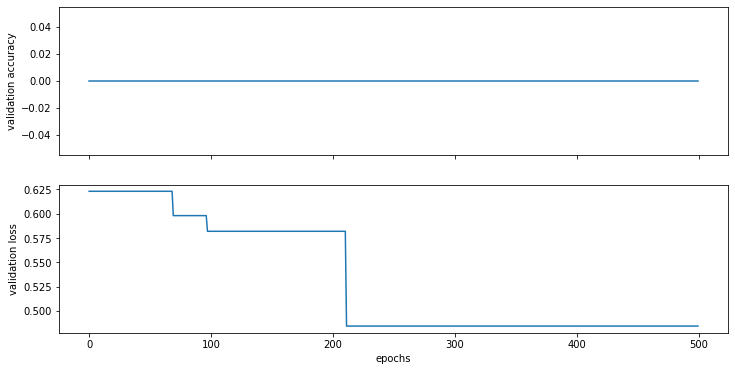

In [157]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");